# Finetuning CNNs on medical image data

The objective of this homework is to use deep learning to recognize tumors in tissue image. We will use the [PCAM](https://github.com/basveeling/pcam) dataset consisting of "327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections".

**Note:** This homework will require intensive computations. It is thus preferable to use GPUs, for example with Google Colab (free access to GPUs).

In [1]:
!pip install --quiet torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time


!pip install --quiet --upgrade "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import HW01
HW01.check_install(requires="0.7.1")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
[DONE] Install ok. Version is v0.7.1


Version v0.7.1 or above of this module is required to bypass an error in torchvision's dataset download.
If the module version does not update when you re-run the previous cell, restart the Kernel of the notebook.
If you get an error on this cell, it is probably because the module did not update: restart your notebook Kernel and try again.

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Data preprocessing

First, download the PCAM dataset using torchvision (see [documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.PCAM.html#torchvision.datasets.PCAM)). To keep computation times low, we will use the validation set (parameter `split='val'`) as train set (variable name `data_train`), and the test set (parameter `split='test'`) as test (variable name `data_test`). Plot the first 5 images of the train set corresponding to a tumor and the 5 first corresponding to healthy tissue. Can you see a difference?

**Note:** If you get an error with the function provided by torchvision to download PCAM, please use `HW1.PCAM(...)` instead of `datasets.PCAM(...)`. This will download the dataset from another source, but will be slower (approx. 10 minutes).

In [3]:
try:
    data_train = datasets.PCAM(root='./data', split='val', download=True)
    data_test = datasets.PCAM(root='./data', split='test', download=True)
except Exception as e:
    print(f"Error downloading PCAM using torchvision: {e}")
    data_train = HW01.PCAM(root='./data', split='val', download=True)
    data_test = HW01.PCAM(root='./data', split='test', download=True)


Error downloading PCAM using torchvision: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3

but Gdown can't. Please check connections and permissions.
Using mirror: https://www.robindar.com/pcam-hw01/camelyonpatch_level_2_split_valid_x.h5.gz
Using mirror: https://www.robindar.com/pcam-hw01/camelyonpatch_level_2_split_valid_y.h5.gz
Using mirror: https://www.robindar.com/pcam-hw01/camelyonpatch_level_2_split_test_x.h5.gz
Using mirror: https://www.robindar.com/pcam-hw01/camelyonpatch_level_2_split_test_y.h5.gz


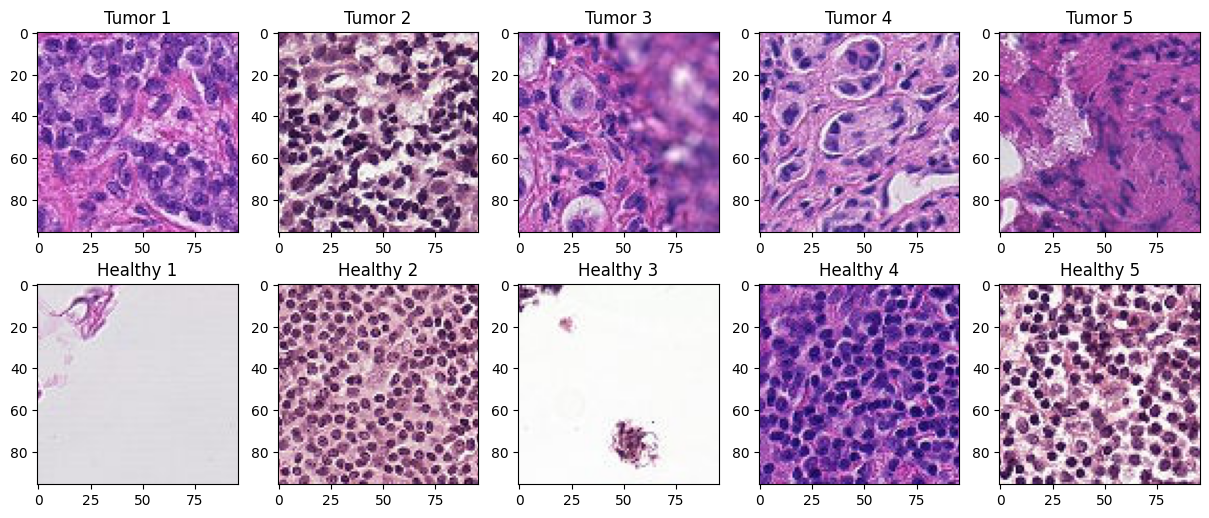

In [4]:
# Plot code (separated from the downloading code)

tumor_indices = []
healthy_indices = []

for i, (image, label) in enumerate(data_train):
    if label == 1 and len(tumor_indices) < 5:
        tumor_indices.append(i)
    elif label == 0 and len(healthy_indices) < 5:
        healthy_indices.append(i)
    if len(tumor_indices) >= 5 and len(healthy_indices) >= 5:
        break  #Stop  once we have 5 samples

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(data_train[tumor_indices[i]][0])
    axes[0, i].set_title(f"Tumor {i+1}")

    axes[1, i].imshow(data_train[healthy_indices[i]][0])
    axes[1, i].set_title(f"Healthy {i+1}")

plt.show()

The difference is that ...

Use `data_train.transform` and `data_test.transform` (see the [documentation](https://pytorch.org/vision/0.9/transforms.html)) to turn the images into tensors (of shape (3,96,96)) and normalize them using `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`, and verify that your data has the correct shape. How many elements are in your train and test sets?

In [5]:
data_train.transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

print(f"Image shape: {data_train[0][0].shape}")

data_test.transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

print(f"Image shape: {data_test[0][0].shape}")


Image shape: torch.Size([3, 96, 96])
Image shape: torch.Size([3, 96, 96])


Now create a train and a test dataloader with a batch size of 64, and a random permutation for the train dataloader (with `shuffle=True`). How many mini-batches do you have?

In [56]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=False)

print(f"Number of mini-batches in the train loader: {len(train_loader)}")
print(f"Number of mini-batches in the test loader: {len(test_loader)}")

print(len(data_train)//64)
print(len(data_test)//64)

Number of mini-batches in the train loader: 512
Number of mini-batches in the test loader: 512
512
512


The number of minibatches is indeed equal to : `len(data)//batch_size`



## Training and testing loop

Write a function `train_model(model, dataloader, epochs)` that performs `epochs` training epochs using the Adam optimizer (with learning rate $10^{-3}$ and a weight decay of $10^{-1}$) on the cross entropy loss (using `nn.CrossEntropyLoss()`) for the model and data provided as input. **Note:** Remember to set the model to training mode using `model.train()`, and put the model and tensors on the correct device (CPU or GPU) by using `x.to(device)`. Plot the loss and accuracy of the model over the train set at each epoch.

In [39]:
lr =0.001
decay = 0.1

def train_model(model,dataloader,epochs):
    model.train()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    losses = []
    accuracies = []

    #lists to store test metrics to plot simultaneously at each epoch
    # test_losses = []
    # test_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.
        running_correct = 0
        total = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.argmax(outputs, 1)
            running_correct += torch.sum(predicted == targets).item()

            total += targets.size(0)

        epoch_loss = running_loss/total
        epoch_accuracy = 100 * running_correct / total

        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)


        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')


        # it's easier to incorporate the testing metrics in this function instead of retraining in the next question
        # test_loss, test_acc = test_model(model, test_loader)
        # test_losses.append(test_loss)
        # test_accuracies.append(test_acc)



    # Train Plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), accuracies, marker='o', linestyle='-')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.show()

    # Test Plots
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, epochs + 1), test_losses, marker='o', linestyle='-')
    # plt.title('Test Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')

    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, epochs + 1), test_accuracies, marker='o', linestyle='-')
    # plt.title('Test Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy (%)')
    # plt.show()


:Now write a function `test_model(model,dataloader)` that plots the loss and accuracy of the model on the whole dataset.

In [57]:
def test_model(model, dataloader):
    model.to(device)
    model.eval()
    running_loss, running_acc, total = 0., 0, 0
    criterion = nn.CrossEntropyLoss()
    # Lists to store loss and accuracy
    losses = []
    accuracies = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            preds = torch.argmax(outputs,1)

            losses.append(loss.item())
            accuracies.append(100 * torch.sum(preds == targets).item() / targets.size(0))

            running_loss += loss.item()
            running_acc += torch.sum(preds == targets).item()
            total += targets.size(0)

    loss = running_loss / total
    acc = 100*running_acc / total

    print(f'Test Loss: {loss:.4f}, Test Accuracy: {acc:.2f}%')

    # Batch Plots (commented out for better visibility)
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # ax1.plot(losses, label='Loss per Batch')
    # ax1.set_title('Loss over Test Data')
    # ax1.set_xlabel('Batch Number')
    # ax1.set_ylabel('Loss')
    # ax1.legend()

    # ax2.plot(accuracies, label='Accuracy per Batch')
    # ax2.set_title('Accuracy over Test Data')
    # ax2.set_xlabel('Batch Number')
    # ax2.set_ylabel('Accuracy (%)')
    # ax2.legend()

    # plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Bar plot for test loss
    ax[0].bar(['Test Loss'], [loss])
    ax[0].set_title('Test Loss')
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel('Loss')

    # Bar plot for test accuracy
    ax[1].bar(['Test Accuracy'], [acc])
    ax[1].set_title('Test Accuracy')
    ax[1].set_ylim(0, 100)
    ax[1].set_ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()


    # return loss, acc # if we want to plot the test metrics for each epoch of the training

Note :
As in the question it is not clear whether we should plot the test accuracies and losses as a function of epochs or simply the final values, I included the plots for each epoch in the `train_model` which calls for the test function and plots both the training accuracies and the testing ones for each epoch. (I commented out the test plots in the training function to lighten the computation).
Also we can plot the accuracy and loss per batch in the `test_model` function. In the doubt of which plot exactly is expected, I plotted also simple bars of the total loss and total accuracy over the testing data.

## Training a linear model

We now test a baseline model on our classification task: a simple linear model. Create a model using `nn.Sequential` that takes images, flatten them into vectors, and then compute a linear model out of it. The output should be 2-dimensional (to match our 2 classes). Then, train it for 2 epochs and test it on the test dataset.

Epoch 1/2, Train Loss: 0.0292, Train Accuracy: 58.20%
Epoch 2/2, Train Loss: 0.0228, Train Accuracy: 62.65%


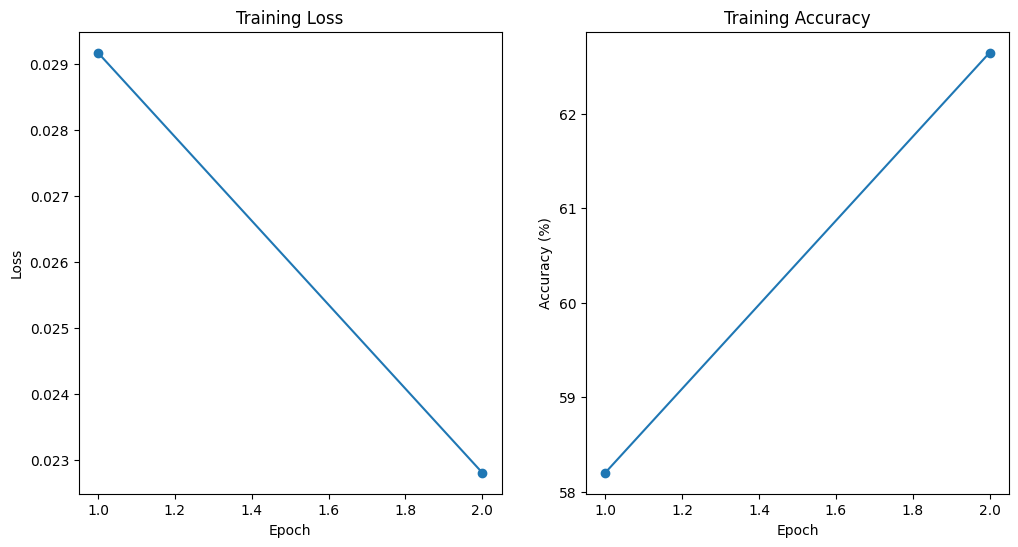

Test Loss: 0.0247, Test Accuracy: 54.54%


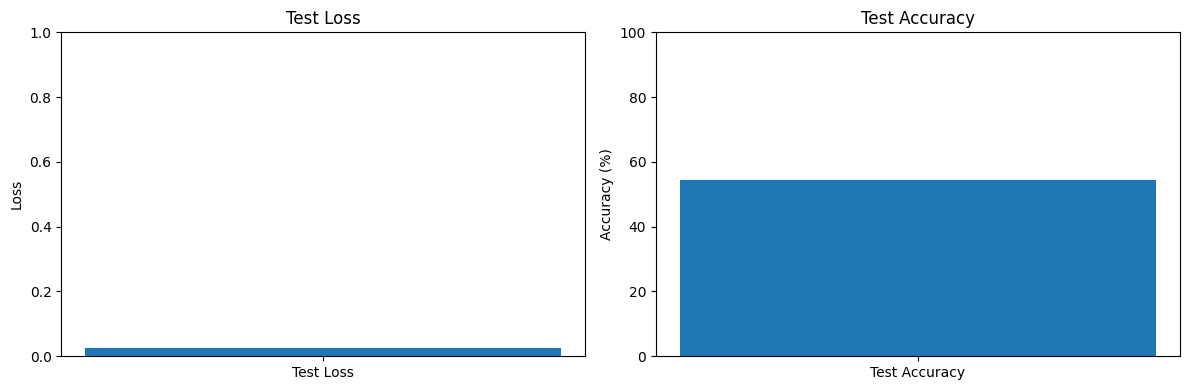

CPU times: user 2min 15s, sys: 18.3 s, total: 2min 34s
Wall time: 2min 33s


In [58]:
%%time

linear_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 96 * 96, 2)
)

train_model(linear_model, train_loader, epochs=2)

test_model(linear_model, test_loader)



## Fine-tuning a CNN model

We are now going to fine-tune a VGG model trained on [ImageNet](http://www.image-net.org/) (1.2M training images). The torchvision module comes with a zoo of pretrained popular CNN architectures. When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`. For next calls, the model will be directly read from there.

First, load the VGG model using `models.vgg16(weights='DEFAULT')` and print it to see its architecture.

In [59]:
vgg = models.vgg16(weights='DEFAULT')
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Note that the model is divided into two part: a **feature** section mainly made of convolutions and pooling layers, and a **classifier** part made of an MLP. We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

The idea of fine-tuning is that the features computed by VGG for Imagenet may be also good for other applications (e.g. for medical images). Replace the last layer of the `model_vgg.classifier` by a new linear layer that outputs 2 values (one for each class), and **freeze** all the other parameters of the VGG model by using `parameter.requires_grad=False` on all the parameters of the model except for the last layer.

In [60]:

vgg.classifier[6] = nn.Linear(4096, 2)

for param in vgg.features.parameters():
    param.requires_grad = False
for param in vgg.classifier[:-1].parameters():
    param.requires_grad = False

#unfreeze the last layer
vgg.classifier[6].requires_grad = True


Now fine-tune the model by performing 2 epochs of training.

Epoch 1/2, Train Loss: 0.0074, Train Accuracy: 77.30%
Epoch 2/2, Train Loss: 0.0072, Train Accuracy: 77.99%


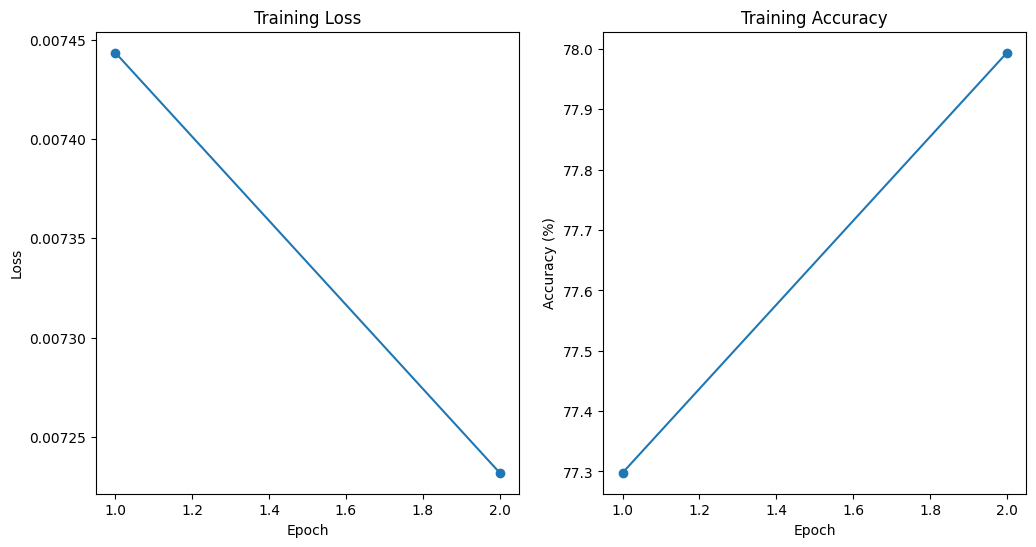

Test Loss: 0.0082, Test Accuracy: 78.79%


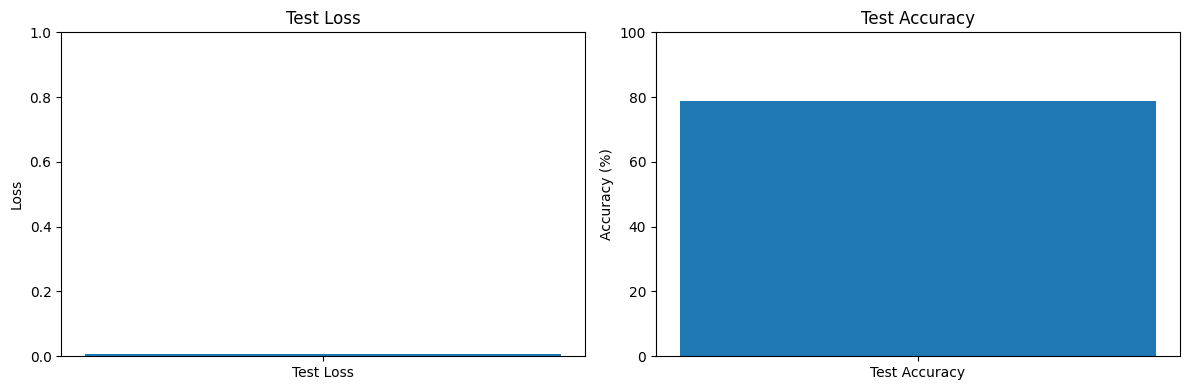

CPU times: user 2min 29s, sys: 18.7 s, total: 2min 47s
Wall time: 2min 46s


In [61]:
%%time

vgg.to(device)

train_model(vgg, train_loader, epochs=2)
test_model(vgg, test_loader)

## Speeding-up training by precomputing features

We are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

Write a function `precompute_model(model, dataloader)` that takes a model and a dataloader as input, and returns a dataset containing the outputs of the model as input using `torch.utils.data.TensorData`.

In [62]:
def precompute_model(model,dataloader):
    model.eval()
    model.to(device)
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model.features(inputs)
            features.append(outputs)
            labels.append(targets)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return torch.utils.data.TensorDataset(features, labels)


Use `precompute_model` to create a DataLoader for the train and test dataset with precomputed VGG features.

In [63]:
%%time

precomputed_train = precompute_model(vgg,train_loader)
precomputed_test = precompute_model(vgg,test_loader)

precomputed_train_loader = torch.utils.data.DataLoader(precomputed_train, batch_size=64, shuffle=True)
precomputed_test_loader = torch.utils.data.DataLoader(precomputed_test, batch_size=64, shuffle=False)


CPU times: user 1min 29s, sys: 11.6 s, total: 1min 41s
Wall time: 1min 41s


Finally, train a linear model on the new precomputed features for 10 epochs. Is the model better?

Epoch 1/10, Train Loss: 0.0056, Train Accuracy: 84.19%
Epoch 2/10, Train Loss: 0.0051, Train Accuracy: 85.94%
Epoch 3/10, Train Loss: 0.0051, Train Accuracy: 85.89%
Epoch 4/10, Train Loss: 0.0050, Train Accuracy: 86.25%
Epoch 5/10, Train Loss: 0.0051, Train Accuracy: 85.96%
Epoch 6/10, Train Loss: 0.0049, Train Accuracy: 86.59%
Epoch 7/10, Train Loss: 0.0050, Train Accuracy: 86.28%
Epoch 8/10, Train Loss: 0.0050, Train Accuracy: 86.43%
Epoch 9/10, Train Loss: 0.0050, Train Accuracy: 86.26%
Epoch 10/10, Train Loss: 0.0050, Train Accuracy: 86.44%


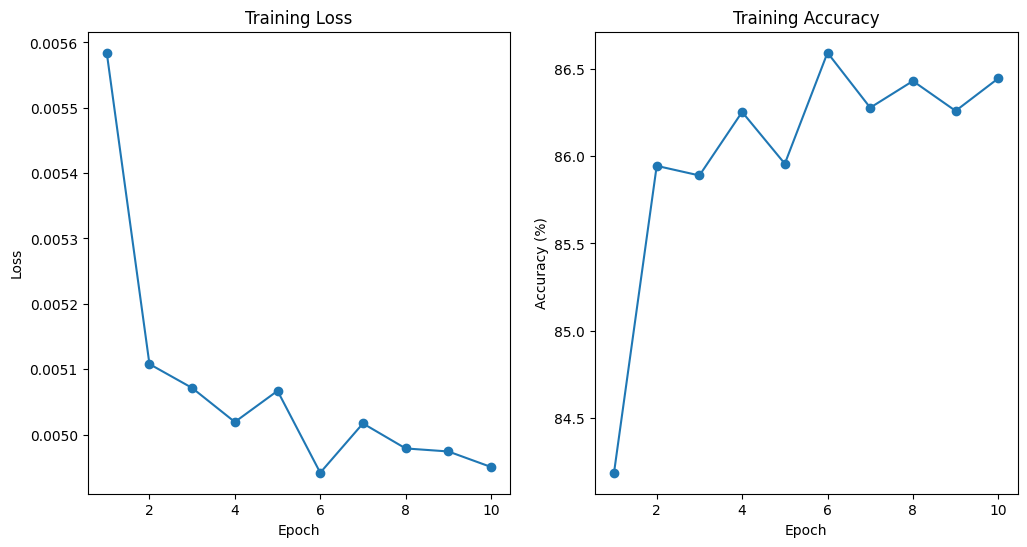

Test Loss: 0.0097, Test Accuracy: 78.49%


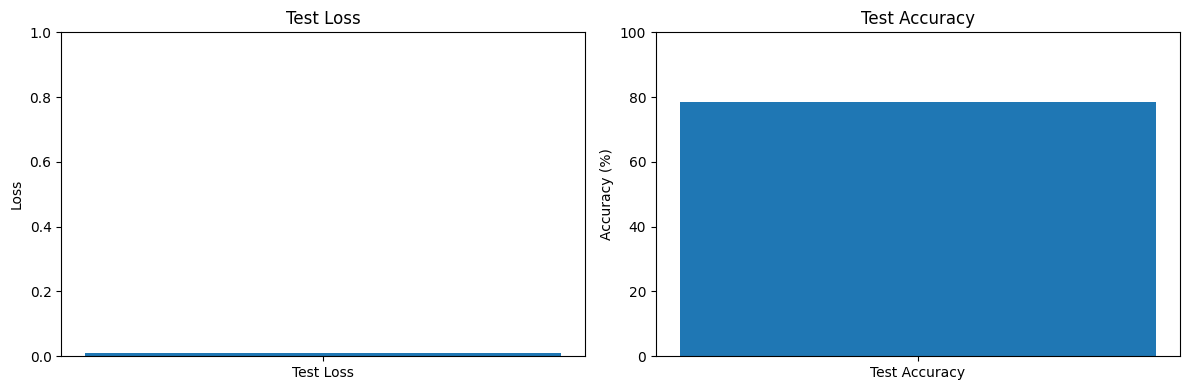

CPU times: user 9.77 s, sys: 609 ms, total: 10.4 s
Wall time: 9.88 s


In [69]:
%%time

input_size = precomputed_train[0][0].shape[0] * precomputed_train[0][0].shape[1] * precomputed_train[0][0].shape[2]

linear_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size , 2)
)

linear_model.to(device)


train_model(linear_model, precomputed_train_loader, 10)
test_model(linear_model, precomputed_test_loader)

This model trains way faster than the previous one : 10 seconds runtime for 10 epochs as opposed to 2-3 minutes for 2 epoch training of the vgg and linear models without precomputing. The training accuracy is also way higher and the loss lower (86% after 2 epochs vs 78% for vgg, and 0.005 vs 0.007), the testing accuracy is in the same range. So in conclusion considering the overall performance and the runtime, this model is better.